In [1]:
import torch

In [2]:

if torch.backends.mps.is_available():
    torch_device = torch.device("mps:0")
    x = torch.ones(1, device=torch_device)
    print (x)
elif torch.cuda.is_available():
    torch_device = torch.device("cuda")
    print ("MPS device not found. Using CUDA.")
else:
    torch_device = torch.device("cpu")
    print ("No accelerator device found. Using CPU.")

MPS device not found. Using CUDA.


## Module

In [3]:
import torch.nn as nn

EMBEDDING_DIM = 3
CONTEXT_LENGTH = 4
QKV_DIM = 2

class CausalSelfAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length=CONTEXT_LENGTH, dropout=0.5, qkv_bias=False):
        super().__init__()
        self.d_in = d_in
        self.d_out = d_out
        self.w_q = nn.Linear(d_in, d_out, bias=qkv_bias).to(torch_device)
        self.w_k = nn.Linear(d_in, d_out, bias=qkv_bias).to(torch_device)
        self.w_v = nn.Linear(d_in, d_out, bias=qkv_bias).to(torch_device)
        self.dropout = nn.Dropout(dropout).to(torch_device)
        self.register_buffer(
            'mask', 
            torch.triu(
                torch.ones(context_length, context_length), 
                diagonal=1,
            ).to(torch_device)
        )

    def forward(self, x):
        num_tokens = x.shape[-2]
        queries = self.w_q(x)
        keys = self.w_k(x)
        attn_scores = queries @ keys.transpose(-2, -1)
        causal_attn_scores = attn_scores.masked_fill_(self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)
        causal_attn_weights = torch.softmax(causal_attn_scores*(self.d_out**0.5), dim=-1)
        causal_attn_weights = self.dropout(causal_attn_weights)
        values = self.w_v(x)
        context = causal_attn_weights @ values
        return context

In [4]:
import torch.nn as nn

EMBEDDING_DIM = 3
CONTEXT_LENGTH = 4
QKV_DIM = 2

class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = d_out//num_heads
        self.w_q = nn.Linear(d_in, d_out, bias=qkv_bias).to(torch_device)
        self.w_k = nn.Linear(d_in, d_out, bias=qkv_bias).to(torch_device)
        self.w_v = nn.Linear(d_in, d_out, bias=qkv_bias).to(torch_device)
        self.w_o = nn.Linear(d_out, d_out).to(torch_device)
        # self.w_o = nn.Identity().to(torch_device)
        self.dropout = nn.Dropout(dropout).to(torch_device)
        self.register_buffer(
            'mask', 
            torch.triu(
                torch.ones(context_length, context_length), 
                diagonal=1,
            ).to(torch_device)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        keys = self.w_k(x)
        queries = self.w_q(x)
        values = self.w_v(x)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim).transpose(-3, -2)
        # TODO: KV Cache Optimization
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim).transpose(-3, -2)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim).transpose(-3, -2)
        attn_scores = queries @ keys.transpose(-2, -1)
        causal_attn_scores = attn_scores.masked_fill_(self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)
        causal_attn_weights = torch.softmax(causal_attn_scores/(keys.shape[-1]**0.5), dim=-1)
        causal_attn_weights = self.dropout(causal_attn_weights)
        context = (causal_attn_weights @ values).transpose(-3, -2)
        context = context.contiguous().view(b, num_tokens, self.num_heads*self.head_dim)
        context = self.w_o(context)
        return context

## Model

In [5]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False,
}

In [6]:
class LayerNorm(nn.Module):
    def __init__(self, d_model, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.scale = nn.Parameter(torch.ones(d_model))
        self.shift = nn.Parameter(torch.zeros(d_model))

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True, unbiased=False)
        x = (self.scale * (x - mean) / (std + self.eps)) + self.shift
        return x

In [7]:
class GELU(nn.Module):
    def forward(self, x):
        return 0.5 * x * (
            1 + torch.tanh(
                torch.sqrt(torch.tensor(2.0/torch.pi, device=torch_device)) * (x  + 0.044715 * x**3)
            )
        )

In [8]:
class FeedForward (nn.Module):
    def __init__(self, cfg): 
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], cfg["emb_dim"]*4).to(torch_device),
            GELU().to(torch_device),
            nn.Linear(cfg["emb_dim"]*4, cfg["emb_dim"]).to(torch_device),
        )

    def forward(self, x):
        return self.layers(x)

In [9]:
class TransformerBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln1 = LayerNorm(config["emb_dim"]).to(torch_device)
        self.attn = MultiHeadAttention(config["emb_dim"], config["emb_dim"], config["context_length"], config["drop_rate"], config["n_heads"], config["qkv_bias"]).to(torch_device)
        self.drop = nn.Dropout(config["drop_rate"]).to(torch_device)
        self.ln2 = LayerNorm(config["emb_dim"]).to(torch_device)
        self.ff = FeedForward(config).to(torch_device)

    def forward(self, x):
        x = self.drop(self.attn(self.ln1(x))) + x
        x = self.drop(self.ff(self.ln2(x))) + x
        return x

In [10]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"]).to(torch_device)
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"]).to(torch_device)
        self.drop_emb = nn.Dropout(cfg["drop_rate"]).to(torch_device)
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        ).to(torch_device)
        self.final_norm = LayerNorm(cfg["emb_dim"]).to(torch_device)
        # GPT2 uses tied weights for the embedding and output layers
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False).to(torch_device)

    def forward(self, in_idx):
        in_idx = in_idx.to(torch_device)
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=torch_device))
        x = self.drop_emb(tok_embeds + pos_embeds)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [11]:
def generate_text_simple(model, token_ids, max_new_tokens, context_size):
    logits = None
    for i in range(max_new_tokens):
        context_token_ids = token_ids[:, -context_size:]
        with torch.no_grad():
            logits = model(context_token_ids)
        if isinstance(logits, tuple):
            logits = logits.logits

        logits = logits[:, -1, :]
        probas = torch.softmax(logits, dim=-1)
        token_id_next = torch.argmax(probas, dim=1, keepdim=True)  # Pure Greed
        token_ids = torch.cat((token_ids, token_id_next), dim=1) 

    return token_ids

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special=set(['<|endoftext|>']))
    encoded_tensor = torch.tensor(encoded).unsqueeze(0).to(torch_device)
    return encoded_tensor

In [12]:
def loss_fn(logits, targets):
    vocab_size = logits.shape[-1]
    loss = nn.CrossEntropyLoss()(logits.view(-1, vocab_size), targets.view(-1))
    return loss

In [13]:
import tiktoken
import torch
from torch.utils.data import Dataset, DataLoader
tokenizer = tiktoken.get_encoding("gpt2")

class GPTDatasetV1(Dataset):
#     def __init__(self, txt, tokenizer, max_length, stride):
#         self.input_ids = []
#         self.target_ids = []
#         token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})
#         token_ids = token_ids
#         token_ids = torch.tensor(token_ids).to(torch_device)
#         print(token_ids.shape)
#         token_sequences = token_ids.unfold(0, max_length, stride)
#         self.input_ids = token_sequences[:-1]
#         self.target_ids = token_sequences[1:]

    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

def create_dataloader_v1(
        txt, batch_size=4, max_length=256, 
        stride=128, shuffle=True, drop_last=True,
        num_workers=0,
    ):
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)
    return DataLoader(
        dataset, 
        batch_size=batch_size, 
        shuffle=shuffle,
        drop_last=drop_last,
    )

In [14]:
def calc_loss_batch(input_batch, target_batch, model, device=torch_device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(
        logits.view(-1, logits.shape[-1]), 
        target_batch.view(-1),
    )
    return loss

In [15]:
def calc_loss_loader(dataloader, model, device, num_batches=None):
    total_loss = 0
    if len(dataloader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(dataloader)
    else:
        num_batches = min(num_batches, len(dataloader))
    for i, (input_batch, target_batch) in enumerate(dataloader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

## Train

In [16]:
def evaluate_model(model, train_dataloader, test_dataloader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_dataloader, model, device, num_batches=eval_iter)
        test_loss = calc_loss_loader(test_dataloader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, test_loss

def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    token_ids = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(model, token_ids, 50, context_size)
    decoded_text = tokenizer.decode(token_ids[0].tolist())
    print(decoded_text.replace("\n", " "))
    model.train()

In [17]:
def train_model_simple(
    model, train_dataloader, test_dataloader,
    optimizer, device, num_epochs,
    eval_freq, eval_iter, start_context, tokenizer
):
    train_losses, test_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_dataloader:
            optimizer.zero_grad()
            # print(input_batch)
            # print(target_batch)
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            loss.backward()
            # grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            # print(f"Gradient norm: {grad_norm:.4f}")
            optimizer.step()
            tokens_seen += input_batch.numel()
            global_step += 1

            if global_step %eval_freq == 0:
                train_loss, test_loss = evaluate_model(
                    model, train_dataloader, test_dataloader, device, eval_iter
                )
                train_losses.append(train_loss)
                test_losses.append(test_loss)
                track_tokens_seen.append(tokens_seen)
                print(
                    f"Epoch {epoch + 1} (Step {global_step:06d}): "
                    f"Train Loss: {train_loss:.3f}, "
                    f"Val Loss: {test_loss:.3f}"
                )

        generate_and_print_sample(
            model, tokenizer, device, start_context
        )
    return train_losses, test_losses, track_tokens_seen


In [18]:
with open("../data/the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

train_ratio = 0.9
split_idx = int(len(raw_text) * train_ratio)
train_data = raw_text[:split_idx]
test_data = raw_text[split_idx:]

torch.manual_seed(123)
train_dataloader = create_dataloader_v1(train_data, batch_size=2, max_length=GPT_CONFIG_124M["context_length"], stride=GPT_CONFIG_124M["context_length"], shuffle=True)
test_dataloader = create_dataloader_v1(test_data, batch_size=2, max_length=GPT_CONFIG_124M["context_length"], stride=GPT_CONFIG_124M["context_length"], shuffle=False)

In [19]:
# train_data[:100], test_data[:100]
# tokenizer = tiktoken.get_encoding("gpt2")
# tokenizer.encode(train_data[:100], allowed_special={"<|endoftext|>"})
# len(train_dataloader), len(test_dataloader)
# input_sample, target_sample = next(iter(train_dataloader))
# torch.sum(input_sample[1]), torch.sum(target_sample[1])
# input_sample.shape, 
# input_sample[1],target_sample[1]

In [20]:
torch.manual_seed(123)
gpt = GPTModel(GPT_CONFIG_124M).to(torch_device)#.to(torch.bfloat16)
# gpt = torch.compile(gpt).to(torch_device)
optimizer = torch.optim.AdamW(
    gpt.parameters(),
    lr = 0.0004, weight_decay = 0.1
)
num_epochs = 10

In [21]:
train_losses, test_losses, track_tokens_seen = train_model_simple(
    gpt, train_dataloader, test_dataloader, optimizer, torch_device,
    num_epochs, eval_freq=5, eval_iter=5, start_context="Every effort moves you", tokenizer=tokenizer,
)

Epoch 1 (Step 000000): Train Loss: 9.817, Val Loss: 9.928
Epoch 1 (Step 000005): Train Loss: 8.065, Val Loss: 8.336
Every effort moves you,,,,,,,,,,,,.                                     
Epoch 2 (Step 000010): Train Loss: 6.622, Val Loss: 7.052
Epoch 2 (Step 000015): Train Loss: 6.047, Val Loss: 6.601
Every effort moves you, and,, and,,,,,,, and,.                                   
Epoch 3 (Step 000020): Train Loss: 5.587, Val Loss: 6.477
Epoch 3 (Step 000025): Train Loss: 5.535, Val Loss: 6.404
Every effort moves you, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and
Epoch 4 (Step 000030): Train Loss: 5.157, Val Loss: 6.386
Epoch 4 (Step 000035): Train Loss: 4.991, Val Loss: 6.385
Every effort moves you a a so a a a. Gisburn, and a. Gisburn, and a, and a.            "I the of the of the picture and he had been. I
Epoch 5 (Step 000040): Train Loss: 4.366, Val Loss: 6.265
Every effort moves you, I had been a--as

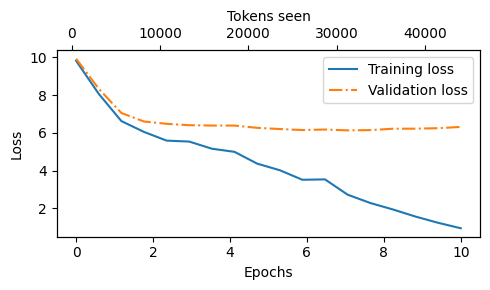

In [22]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, test_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, test_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, track_tokens_seen, train_losses, test_losses)

## Decode

In [24]:
generate_and_print_with_decoding(gpt, tokenizer, torch_device, "Every effort moves you", greedy)

Every effort moves you?"  "Yes--quite insensible to the irony. She wanted him vindicated--and by me!"     "I didn't face that he had married her--the quality of the a fashionable painter--and by holding


In [25]:
def print_top_tokens(model, token_ids, max_new_tokens, context_size, top_k=5):
    logits = None
    for i in range(max_new_tokens):
        context_token_ids = token_ids[:, -context_size:]
        with torch.no_grad():
            logits = model(context_token_ids)

        logits = logits[:, -1, :]
        probas = torch.softmax(logits, dim=-1)
        token_id_next = torch.multinomial(probas, num_samples=1)  # Pure Random
        token_ids = torch.cat((token_ids, token_id_next), dim=1) 
        # Print the top-k tokens
        topk_probs, topk_tokens = torch.topk(probas, top_k, dim=-1)
        for topk_prob, topk_token in zip(topk_probs[0], topk_tokens[0]):
            token_str = tokenizer.decode([topk_token])
            print(f"{token_str}: {topk_prob:.4f}")
    
    return token_ids

In [26]:
def random(model, token_ids, max_new_tokens, context_size, temperature=1.0):
    logits = None
    if temperature == 0:
        return greedy(model, token_ids, max_new_tokens, context_size)
    for i in range(max_new_tokens):
        context_token_ids = token_ids[:, -context_size:]
        with torch.no_grad():
            logits = model(context_token_ids)

        logits = logits[:, -1, :]
        probas = torch.softmax(logits/temperature, dim=-1)
        token_id_next = torch.multinomial(probas, num_samples=1)  # Pure Random
        token_ids = torch.cat((token_ids, token_id_next), dim=1) 

    return token_ids

In [27]:
generate_and_print_with_decoding(gpt, tokenizer, torch_device, "Every effort moves you", print_top_tokens)

?": 0.1868
 know: 0.1075
 in: 0.0496
 of: 0.0183
 sun: 0.0182
 terr: 0.0424
 to: 0.0277
 began: 0.0208

: 0.0170
agged: 0.0149
 him: 0.1311
nt: 0.0391
 work: 0.0168
 never: 0.0152
 bitterness: 0.0146
 of: 0.0908
 up: 0.0900
 to: 0.0164
 with: 0.0164
,: 0.0102
 it: 0.3579
 that: 0.1691
 a: 0.0327
 and: 0.0189
-: 0.0130
 was: 0.1165
 happened: 0.0379
 all: 0.0323
 the: 0.0245
?": 0.0213
 one: 0.0809
 a: 0.0749
 Mrs: 0.0502
ed: 0.0339
 dead: 0.0257
 he: 0.2288
 for: 0.0357
 by: 0.0220
 doesn: 0.0208
 ins: 0.0165
--: 0.2171
 to: 0.2015
.: 0.0157
 was: 0.0136
 after: 0.0118
as: 0.0674
I: 0.0672
and: 0.0671
his: 0.0561
so: 0.0403
 the: 0.9259
 that: 0.0145
,: 0.0091
 his: 0.0066
 a: 0.0011
 fact: 0.3842
 irony: 0.1359
 picture: 0.0216
 tone: 0.0161
-: 0.0055
chairs: 0.4696
rooms: 0.0244
hum: 0.0237
piece: 0.0114
century: 0.0110
 forward: 0.7530
.: 0.0106
 his: 0.0080
 to: 0.0066
 me: 0.0041
.: 0.9073
 of: 0.0195
 in: 0.0057
anim: 0.0024
 was: 0.0012
 I: 0.2968
 ": 0.1636

: 0.1337
 G: 0.0597

In [28]:
from functools import partial
generate_and_print_with_decoding(gpt, tokenizer, torch_device, "Every effort moves you", partial(random, temperature=0.5))

Every effort moves you?"  "Yes--quite insensible to the irony. She wanted him vindicated--and by me!"   He laughed of the moment--as Jack himself, and he was have him done by a fashionable painter--and by holding


In [30]:
# temp = torch.rand((10, 10))
# vals, inds = torch.topk(temp, dim=-1, k=3)
# mask = torch.ones_like(temp, dtype=torch.bool).scatter_(-1, inds, False)
# print(mask)
# topk_temp = temp.masked_fill_(mask, -torch.inf)
# torch.softmax(topk_temp, dim=-1)

In [31]:
generate_and_print_with_decoding(gpt, tokenizer, torch_device, "Every effort moves you", partial(topk, temperature=0.5, k=3))

Every effort moves you?"  "Yes--quite insensible to the irony. "Oh, with a yourself comfortable--and here are the cigars you like."  I looked at the donkey--and I had the donkey. "There were days when I


In [32]:
def minp(model, token_ids, max_new_tokens, context_size, temperature=1.0, minp=0.9):
    logits = None
    if temperature == 0:
        return greedy(model, token_ids, max_new_tokens, context_size)
    for i in range(max_new_tokens):
        context_token_ids = token_ids[:, -context_size:]
        with torch.no_grad():
            logits = model(context_token_ids)

        logits = logits[:, -1, :]
        probas = torch.softmax(logits/temperature, dim=-1)
        sorted_probas, sorted_indices = torch.sort(probas, descending=True, dim=-1)
        cumulative_probas = torch.cumsum(sorted_probas, dim=-1)
        minp_mask = cumulative_probas > minp
        unsorted_minp_mask = torch.zeros_like(probas, dtype=torch.bool).scatter_(-1, sorted_indices, minp_mask)
        sum_prob = torch.sum(sorted_probas.masked_fill_(minp_mask, 0), dim=-1)
        if sum_prob == 0:
            token_id_next = torch.argmax(probas, dim=-1, keepdim=True)  # Pure Greed
            token_ids = torch.cat((token_ids, token_id_next), dim=1) 
        else:
            minp_probas = probas.masked_fill_(unsorted_minp_mask, 0)/sum_prob
            token_id_next = torch.multinomial(minp_probas, num_samples=1)  # Pure Random
            token_ids = torch.cat((token_ids, token_id_next), dim=1) 

    return token_ids

In [33]:
generate_and_print_with_decoding(gpt, tokenizer, torch_device, "Every effort moves you", partial(minp, temperature=1.0, minp=0.9))

Every effort moves you know," was one of the window. The she proveujエ for gar wasn even he was hint of an awful simpleton, that, I don Stroud smile canv to deard Frost the sketch of the donkey. "There were days when I


## Load

In [34]:
torch.save(gpt.state_dict(), "gpt-trained.pth")

In [35]:
loaded_gpt_state = torch.load("gpt-trained.pth", map_location=torch_device)

/tmp/ipykernel_16969/3928202563.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_gpt_state = torch.load("gpt-trained.pth", map_location=torch_device)


In [36]:
loaded_gpt_model = GPTModel(GPT_CONFIG_124M).to(torch_device)
loaded_gpt_model.load_state_dict(loaded_gpt_state)

<All keys matched successfully>

In [37]:
loaded_gpt_model

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (ln1): LayerNorm()
      (attn): MultiHeadAttention(
        (w_q): Linear(in_features=768, out_features=768, bias=False)
        (w_k): Linear(in_features=768, out_features=768, bias=False)
        (w_v): Linear(in_features=768, out_features=768, bias=False)
        (w_o): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (drop): Dropout(p=0.1, inplace=False)
      (ln2): LayerNorm()
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
    )
    (1): TransformerBlock(
      (ln1): LayerNorm()
      (attn): MultiHeadAttention(
        (w_q): Linear(in_features=768,

## Compile

In [38]:
compiled = torch.compile(loaded_gpt_model)

In [39]:
generate_and_print_with_decoding(compiled, tokenizer, torch_device, "Every effort moves you", greedy)

Every effort moves you?"  "Yes--quite insensible to the irony. She wanted him vindicated--and by me!"     "I didn't face that he had married her--the quality of the a fashionable painter--and by holding


## Loading from HF Transformers

In [40]:
from transformers import GPT2LMHeadModel

# Load the model
hf_model = GPT2LMHeadModel.from_pretrained("openai-community/gpt2")

# Extract the weights
hf_model_state_dict = hf_model.state_dict()

/home/jacobjensen/.pyenv/versions/3.11.9/envs/jejllm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def rename(s):
    return s.replace(
        "transformer", "trf"
    ).replace(
        "h.", ""
    ).replace(
        
    )

In [121]:
total_params = sum(p.numel() for p in hf_model.parameters())
total_params_from_state = 0
for k, v in hf_model_state_dict.items():
    print(k, v.shape)
    total_params_from_state += v.numel()
print(total_params, total_params_from_state)

transformer.wte.weight torch.Size([50257, 768])
transformer.wpe.weight torch.Size([1024, 768])
transformer.h.0.ln_1.weight torch.Size([768])
transformer.h.0.ln_1.bias torch.Size([768])
transformer.h.0.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.0.attn.c_attn.bias torch.Size([2304])
transformer.h.0.attn.c_proj.weight torch.Size([768, 768])
transformer.h.0.attn.c_proj.bias torch.Size([768])
transformer.h.0.ln_2.weight torch.Size([768])
transformer.h.0.ln_2.bias torch.Size([768])
transformer.h.0.mlp.c_fc.weight torch.Size([768, 3072])
transformer.h.0.mlp.c_fc.bias torch.Size([3072])
transformer.h.0.mlp.c_proj.weight torch.Size([3072, 768])
transformer.h.0.mlp.c_proj.bias torch.Size([768])
transformer.h.1.ln_1.weight torch.Size([768])
transformer.h.1.ln_1.bias torch.Size([768])
transformer.h.1.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.1.attn.c_attn.bias torch.Size([2304])
transformer.h.1.attn.c_proj.weight torch.Size([768, 768])
transformer.h.1.attn.c_proj.bias 

In [149]:
GPT_CONFIG_124M_ORIGINAL = GPT_CONFIG_124M.copy()
GPT_CONFIG_124M_ORIGINAL["qkv_bias"] = True
GPT_CONFIG_124M_ORIGINAL["context_length"] = 1024
gpt2_small = GPTModel(GPT_CONFIG_124M_ORIGINAL).to(torch_device)

In [150]:
GPT_CONFIG_124M_ORIGINAL

{'vocab_size': 50257,
 'context_length': 1024,
 'emb_dim': 768,
 'n_heads': 12,
 'n_layers': 12,
 'drop_rate': 0.1,
 'qkv_bias': True}

In [151]:
# for p in gpt2_small.parameters():
#     print(p)
for k, v in gpt2_small.state_dict().items():
    print(k, v.shape)
    total_params_from_state += v.numel()
print(total_params, total_params_from_state)

tok_emb.weight torch.Size([50257, 768])
pos_emb.weight torch.Size([1024, 768])
trf_blocks.0.ln1.scale torch.Size([768])
trf_blocks.0.ln1.shift torch.Size([768])
trf_blocks.0.attn.mask torch.Size([1024, 1024])
trf_blocks.0.attn.w_q.weight torch.Size([768, 768])
trf_blocks.0.attn.w_q.bias torch.Size([768])
trf_blocks.0.attn.w_k.weight torch.Size([768, 768])
trf_blocks.0.attn.w_k.bias torch.Size([768])
trf_blocks.0.attn.w_v.weight torch.Size([768, 768])
trf_blocks.0.attn.w_v.bias torch.Size([768])
trf_blocks.0.attn.w_o.weight torch.Size([768, 768])
trf_blocks.0.attn.w_o.bias torch.Size([768])
trf_blocks.0.ln2.scale torch.Size([768])
trf_blocks.0.ln2.shift torch.Size([768])
trf_blocks.0.ff.layers.0.weight torch.Size([3072, 768])
trf_blocks.0.ff.layers.0.bias torch.Size([3072])
trf_blocks.0.ff.layers.2.weight torch.Size([768, 3072])
trf_blocks.0.ff.layers.2.bias torch.Size([768])
trf_blocks.1.ln1.scale torch.Size([768])
trf_blocks.1.ln1.shift torch.Size([768])
trf_blocks.1.attn.mask torch.S

In [152]:
import re

def convert_name(old_name, tensor):
    """
    Convert parameter names from the initial naming convention to the target naming convention.

    Args:
        old_name (str): The original parameter name.
        tensor (torch.Tensor): The tensor associated with the parameter name.

    Returns:
        list of tuples: Each tuple contains the new parameter name and the corresponding slice indices
                        if the old parameter needs to be split. Otherwise, slice indices are None.
                        Example: [("trf_blocks.0.attn.w_q.weight", slice(0, 768))]
    """
    mappings = []

    # Direct mappings
    direct_map = {
        "transformer.wte.weight": "tok_emb.weight",
        "transformer.wpe.weight": "pos_emb.weight",
        "transformer.ln_f.weight": "final_norm.scale",
        "transformer.ln_f.bias": "final_norm.shift",
        "lm_head.weight": "out_head.weight",
    }

    if old_name in direct_map:
        mappings.append((direct_map[old_name], None))
        return mappings

    # Regex patterns for more complex mappings
    layer_pattern = re.compile(r"transformer\.h\.(\d+)\.(ln_1|ln_2|attn\.(c_attn|c_proj)|mlp\.(c_fc|c_proj))\.(weight|bias)")

    match = layer_pattern.match(old_name)
    if match:
        layer_idx, component, sub_component, mlp_component, param_type = match.groups()
        layer_idx = int(layer_idx)

        if component == "ln_1":
            if param_type == "weight":
                new_name = f"trf_blocks.{layer_idx}.ln1.scale"
            else:
                new_name = f"trf_blocks.{layer_idx}.ln1.shift"
            mappings.append((new_name, None))
        elif component == "ln_2":
            if param_type == "weight":
                new_name = f"trf_blocks.{layer_idx}.ln2.scale"
            else:
                new_name = f"trf_blocks.{layer_idx}.ln2.shift"
            mappings.append((new_name, None))
        elif component.startswith("attn.c_attn"):
            if param_type == "weight":
                # Split c_attn.weight into w_q.weight, w_k.weight, w_v.weight
                d_model = tensor.size(1)  # Assuming [768, 2304]
                split_size = d_model // 3
                w_q = f"trf_blocks.{layer_idx}.attn.w_q.weight"
                w_k = f"trf_blocks.{layer_idx}.attn.w_k.weight"
                w_v = f"trf_blocks.{layer_idx}.attn.w_v.weight"
                mappings.extend([
                    (w_q, slice(0, split_size)),
                    (w_k, slice(split_size, 2 * split_size)),
                    (w_v, slice(2 * split_size, 3 * split_size)),
                ])
            elif param_type == "bias":
                d_model = tensor.size(0)
                split_size = d_model // 3
                b_q = f"trf_blocks.{layer_idx}.attn.w_q.bias"
                b_k = f"trf_blocks.{layer_idx}.attn.w_k.bias"
                b_v = f"trf_blocks.{layer_idx}.attn.w_v.bias"
                mappings.extend([
                    (b_q, slice(0, split_size)),
                    (b_k, slice(split_size, 2 * split_size)),
                    (b_v, slice(2 * split_size, 3 * split_size)),
                ])
        elif component.startswith("attn.c_proj"):
            if param_type == "weight":
                new_name = f"trf_blocks.{layer_idx}.attn.w_o.weight"
            else:
                new_name = f"trf_blocks.{layer_idx}.attn.w_o.bias"
            mappings.append((new_name, None))
        elif component.startswith("mlp.c_fc"):
            if param_type == "weight":
                new_name = f"trf_blocks.{layer_idx}.ff.layers.0.weight"
            else:
                new_name = f"trf_blocks.{layer_idx}.ff.layers.0.bias"
            mappings.append((new_name, None))
        elif component.startswith("mlp.c_proj"):
            if param_type == "weight":
                new_name = f"trf_blocks.{layer_idx}.ff.layers.2.weight"
            else:
                new_name = f"trf_blocks.{layer_idx}.ff.layers.2.bias"
            mappings.append((new_name, None))
        return mappings

    # If no mapping found
    print(f"Warning: No mapping found for parameter '{old_name}'")
    return mappings

In [153]:
def convert_state_dict(initial_state_dict):
    target_state_dict = {}
    for old_name, tensor in initial_state_dict.items():
        mapped = convert_name(old_name, tensor)
        for new_name, slice_idx in mapped:
            if slice_idx is not None:
                # If the parameter needs to be split
                new_tensor = tensor[(..., slice_idx)].clone()
                target_state_dict[new_name] = new_tensor
            else:
                if "ff" in new_name and "weight" in new_name:
                    target_state_dict[new_name] = tensor.clone().transpose(0, 1)
                else:
                    target_state_dict[new_name] = tensor.clone()
    return target_state_dict

converted_hf_model_state_dict = convert_state_dict(hf_model_state_dict)

In [154]:
for k, v in hf_model_state_dict.items():
    if "transformer.h.0" in k:
        print(k, v.shape)


transformer.h.0.ln_1.weight torch.Size([768])
transformer.h.0.ln_1.bias torch.Size([768])
transformer.h.0.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.0.attn.c_attn.bias torch.Size([2304])
transformer.h.0.attn.c_proj.weight torch.Size([768, 768])
transformer.h.0.attn.c_proj.bias torch.Size([768])
transformer.h.0.ln_2.weight torch.Size([768])
transformer.h.0.ln_2.bias torch.Size([768])
transformer.h.0.mlp.c_fc.weight torch.Size([768, 3072])
transformer.h.0.mlp.c_fc.bias torch.Size([3072])
transformer.h.0.mlp.c_proj.weight torch.Size([3072, 768])
transformer.h.0.mlp.c_proj.bias torch.Size([768])


In [155]:
for k, v in converted_hf_model_state_dict.items():
    if "trf_blocks.0" in k:
        print(k, v.shape)


trf_blocks.0.ln1.scale torch.Size([768])
trf_blocks.0.ln1.shift torch.Size([768])
trf_blocks.0.attn.w_q.weight torch.Size([768, 768])
trf_blocks.0.attn.w_k.weight torch.Size([768, 768])
trf_blocks.0.attn.w_v.weight torch.Size([768, 768])
trf_blocks.0.attn.w_q.bias torch.Size([768])
trf_blocks.0.attn.w_k.bias torch.Size([768])
trf_blocks.0.attn.w_v.bias torch.Size([768])
trf_blocks.0.attn.w_o.weight torch.Size([768, 768])
trf_blocks.0.attn.w_o.bias torch.Size([768])
trf_blocks.0.ln2.scale torch.Size([768])
trf_blocks.0.ln2.shift torch.Size([768])
trf_blocks.0.ff.layers.0.weight torch.Size([3072, 768])
trf_blocks.0.ff.layers.0.bias torch.Size([3072])
trf_blocks.0.ff.layers.2.weight torch.Size([768, 3072])
trf_blocks.0.ff.layers.2.bias torch.Size([768])


In [156]:
# gpt2_small.trf_blocks[0].ff.layers

In [157]:
for k, v in gpt2_small.state_dict().items():
    if "trf_blocks.0" in k:
        print(k, v.shape)


trf_blocks.0.ln1.scale torch.Size([768])
trf_blocks.0.ln1.shift torch.Size([768])
trf_blocks.0.attn.mask torch.Size([1024, 1024])
trf_blocks.0.attn.w_q.weight torch.Size([768, 768])
trf_blocks.0.attn.w_q.bias torch.Size([768])
trf_blocks.0.attn.w_k.weight torch.Size([768, 768])
trf_blocks.0.attn.w_k.bias torch.Size([768])
trf_blocks.0.attn.w_v.weight torch.Size([768, 768])
trf_blocks.0.attn.w_v.bias torch.Size([768])
trf_blocks.0.attn.w_o.weight torch.Size([768, 768])
trf_blocks.0.attn.w_o.bias torch.Size([768])
trf_blocks.0.ln2.scale torch.Size([768])
trf_blocks.0.ln2.shift torch.Size([768])
trf_blocks.0.ff.layers.0.weight torch.Size([3072, 768])
trf_blocks.0.ff.layers.0.bias torch.Size([3072])
trf_blocks.0.ff.layers.2.weight torch.Size([768, 3072])
trf_blocks.0.ff.layers.2.bias torch.Size([768])


In [158]:
loaded_gpt_state["trf_blocks.1.attn.mask"]

tensor([[0., 1., 1.,  ..., 1., 1., 1.],
        [0., 0., 1.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

In [162]:
gpt2_small.trf_blocks[1].attn.w_q.weight - gpt2_small_with_weights.trf_blocks[1].attn.w_q.weight

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0',
       grad_fn=<SubBackward0>)

In [160]:
def load_weights_into_gpt(gpt, state_dict, backup_state_dict=None):
    if backup_state_dict is not None:
        final_state_dict = backup_state_dict
    else:
        final_state_dict = {}
    final_state_dict.update(state_dict)
    gpt.load_state_dict(final_state_dict)
    return gpt

gpt2_small_with_weights = load_weights_into_gpt(
    gpt2_small, 
    converted_hf_model_state_dict, 
    gpt2_small.state_dict()
)
gpt2_small_with_weights

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (ln1): LayerNorm()
      (attn): MultiHeadAttention(
        (w_q): Linear(in_features=768, out_features=768, bias=True)
        (w_k): Linear(in_features=768, out_features=768, bias=True)
        (w_v): Linear(in_features=768, out_features=768, bias=True)
        (w_o): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (drop): Dropout(p=0.1, inplace=False)
      (ln2): LayerNorm()
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
    )
    (1): TransformerBlock(
      (ln1): LayerNorm()
      (attn): MultiHeadAttention(
        (w_q): Linear(in_features=768, o

In [161]:
generate_and_print_with_decoding(gpt2_small_with_weights, tokenizer, torch_device, "Every effort moves you", topk)

tensor([[[ -8.1808,  -8.0697, -10.9996,  ..., -14.9142, -14.5079,  -8.0091],
         [-11.4183, -11.3589, -14.6981,  ..., -18.7968, -18.2219, -11.8120],
         [-11.1632, -11.0749, -14.1920,  ..., -18.0516, -17.8552, -11.1309],
         [ -9.8438,  -9.7723, -12.6191,  ..., -16.6923, -15.9322,  -9.6007]]],
       device='cuda:0')
tensor([[[ -8.1808,  -8.0697, -10.9996,  ..., -14.9142, -14.5079,  -8.0091],
         [-11.4183, -11.3589, -14.6981,  ..., -18.7968, -18.2219, -11.8120],
         [-11.1632, -11.0749, -14.1920,  ..., -18.0516, -17.8552, -11.1309],
         [ -9.8438,  -9.7723, -12.6191,  ..., -16.6923, -15.9322,  -9.6007],
         [ -9.8205,  -9.6539, -12.5554,  ..., -16.4342, -15.9177,  -9.6153]]],
       device='cuda:0')
tensor([[[ -8.1808,  -8.0697, -10.9996,  ..., -14.9142, -14.5079,  -8.0091],
         [-11.4183, -11.3589, -14.6981,  ..., -18.7968, -18.2219, -11.8120],
         [-11.1632, -11.0749, -14.1920,  ..., -18.0516, -17.8552, -11.1309],
         [ -9.8438,  -9.

In [165]:
def greedy(model, token_ids, max_new_tokens, context_size):
    logits = None
    for i in range(max_new_tokens):
        context_token_ids = token_ids[:, -context_size:]
        with torch.no_grad():
            logits = model(context_token_ids)

        logits = logits[:, -1, :]
        probas = torch.softmax(logits, dim=-1)
        token_id_next = torch.argmax(probas, dim=1, keepdim=True)  # Pure Greed
        token_ids = torch.cat((token_ids, token_id_next), dim=1) 

    return token_ids

def topk(model, token_ids, max_new_tokens, context_size, temperature=1.0, k=5):
    logits = None
    if temperature == 0:
        return greedy(model, token_ids, max_new_tokens, context_size)
    for i in range(max_new_tokens):
        context_token_ids = token_ids[:, -context_size:]
        with torch.no_grad():
            logits = model(context_token_ids)
        if not isinstance(logits, torch.Tensor):
            logits = logits[0]
        logits = logits[:, -1, :]
        scaled_logits = logits/temperature
        _, inds = torch.topk(scaled_logits, dim=-1, k=k)
        mask = torch.ones_like(scaled_logits, dtype=torch.bool).scatter_(-1, inds, False)
        topk_scaled_logits = scaled_logits.masked_fill_(mask, -torch.inf)
        probas = torch.softmax(topk_scaled_logits, dim=-1)
        token_id_next = torch.multinomial(probas, num_samples=1)  # Pure Random
        token_ids = torch.cat((token_ids, token_id_next), dim=1) 

    return token_ids

def generate_and_print_with_decoding(model, tokenizer, device, start_context, decoding_fn, context_size=None):
    model.eval()
    if context_size is None:
        context_size = model.pos_emb.weight.shape[0]
    token_ids = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = decoding_fn(model, token_ids, 50, context_size)
    decoded_text = tokenizer.decode(token_ids[0].tolist())
    print(decoded_text.replace("\n", " "))
    model.train()

In [171]:
generate_and_print_with_decoding(
    hf_model.to(torch_device), 
    tokenizer, 
    torch_device, 
    "Every effort moves you", 
    topk, 
    context_size=1024,
)

Every effort moves you to a higher level. It is your responsibility to make sure you are not only successful in the world, but also the most important. You must make the best decisions for your life.  You must make the best decisions for your life. The
